# Part 1: From _ImageNet_ to _CIFAR_ with Transfer Learning

This notebook may be skipped if the user already has a pre-trained floating point CIFAR-10 / CIFAR-100 model. In what follows, we show you how we used Transfer Learning to train a convolutional floating point neural network.

Nowadays, whether or not you have time and computational resources, very few people train a full convolutional network on a huge data-set from _scratch_, e.g., ImageNet, which has $1.2$ million images and $1000$ categories. In practice, we use Transfer learning a very efficient approach in Machine Learning that aims to save both time and computing power. Transfer learning refers to a set of methods that allow the reuse of knowledge gained from solving a given task and applying it to a different but related task.

Transfer Learning provides a variety of techniques, such as:
- fine-tuning: instead of a random initialization of the weights, it's possible to reuse the pre-trained weights as a starting point
- fixed feature extractor: the pre-trained model is used as a feature extractor and only the output model is fine-tuned to achieve the targeted task. In other words, the final fully connected layer is replaced by a new one with the appropriate output shape. We freeze all the layers except this new one, that is trained.

In our use case, we'll combine the two methods mentioned above. 

## Import the required packages.

In [1]:
import random
import warnings
from copy import deepcopy

import torch
from models import Fp32VGG11
from torchvision import datasets
from utils import get_dataloader, plot_dataset, plot_history, torch_inference, train

warnings.filterwarnings("ignore")

## Settings

In [2]:
batch_size = 128
dataset_name = "CIFAR_100"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_c10 = {
    "output_size": 10,
    "training": "fp32",
    "dataset_name": "CIFAR_10",
    "dataset": datasets.CIFAR10,
    "mean": [0.4914, 0.4822, 0.4465],
    "std": [0.247, 0.243, 0.261],
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_10",
    "seed": 727,
}
param_c100 = {
    "output_size": 100,
    "training": "fp32",
    "dataset_name": "CIFAR_100",
    "dataset": datasets.CIFAR100,
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_100",
    "seed": 727,
}

# In this tutorial, we present the results of CIFAR-100.
if dataset_name == "CIFAR_100":
    param = param_c100
else:
    # If you want to use it for CIFAR-10, set `dataset_name` to "CIFAR_100"
    param = param_c10

print(f"Device Type: {device}")

Device Type: cuda:0


## Data-set

The _CIFAR_ data-sets contain $32*32$ colored images.

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


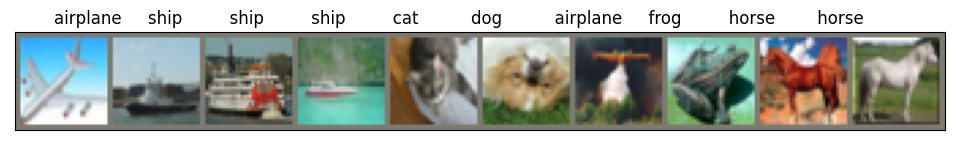

In [3]:
# Load CIFAR-100 or CIFAR-10 data-set according to `dataset_name`.
train_loader, test_loader = get_dataloader(batch_size=batch_size, param=param)

# Let’s visualize `n` images from CIFAR data-set.
plot_dataset(test_loader, param)

## Model's architecture

As this network is meant to run in FHE, we apply several changes on the original [VGG11 architecture](https://pytorch.org/hub/pytorch_vision_vgg/) **in order to speed up the FHE execution** and therefore make it more user-friendly :

- replacing the `MaxPool2d` by the `AvgPool2d`, because in the current version of Concrete-ML `MaxPool2d` isn't available yet
- changing the kernel and stride size in some pooling layers, because we have chosen to keep the initial input size of $3*32*32$ instead of the recommended input size of $3*224*224$
- changing the kernel size from $7$ to $1$ in the `AdaptiveAvgPool2d` to further reduce the image's size
- removing the classification part of the original VGG11 architecture to speed up computation

The model architecture is detailed [here](models.py)

## Load VGG-11 pre-trained weights

In [4]:
torch.manual_seed(param["seed"])
random.seed(param["seed"])

# Instantiation of the custom VGG-11 network.
fp32_vgg = Fp32VGG11(param["output_size"]).to(device)

# Loading the pre-trained VGG-11 weights from torch.hub.
pretrained_weights = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "vgg11",
    pretrained=True,
).state_dict()

# Caution:
# The `fp32_vgg.state_dict()` respects the same schema for the convolutional, ReLU and pooling
# layers (order/shape/naming) as the `pretrained_weights` dict, that's why it doesn't throw an error
fp32_vgg.load_state_dict(deepcopy(pretrained_weights), strict=False)
# We got an IncompatibleKeys warning because
# we deleted the classification layers of the original VGG-11 network.

Using cache found in /home/celia/.cache/torch/hub/pytorch_vision_v0.10.0


_IncompatibleKeys(missing_keys=['final_layer.weight', 'final_layer.bias'], unexpected_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

## Training

For the training part, we combine 2 methods to fine-tune our model.
1. Fine-tuning the final layer: here, the weights are initialized using VGG-11 from torch-hub. We freeze the convolutional layers except the last fully connected final layer, which we train. This approach prevents abrupt gradient propagation.

1. Fine-tuning all the layers: in this case, we unfreeze the convolutional layers and fine-tune the entire network.

### Fine-tuning the final layer

We freeze all the layers except the final fully connected layer, that we fine-tune.

In [5]:
# We freeze all the layers.
for p in list(fp32_vgg.parameters()):
    p.requires_grad = False

# Set the `requires_grad` of the last layer at `True` to fine-tune it.
fp32_vgg.final_layer.weight.requires_grad = True
fp32_vgg.final_layer.bias.requires_grad = True

In [6]:
if dataset_name == "CIFAR_100":
    param["lr"] = 0.06
    param["epochs"] = 10
    param["gamma"] = 0.01
    param["milestones"] = [1]

elif dataset_name == "CIFAR_10":
    param["lr"] = 0.1
    param["epochs"] = 5
    param["gamma"] = 0.1
    param["milestones"] = [1, 3]

fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 2.5805 VS Test loss = 2.2638 - Accuracy train: 0.3615 VS Accuracy test: 0.4532
Epoch  1: Train loss = 2.0140 VS Test loss = 2.0738 - Accuracy train: 0.4737 VS Accuracy test: 0.4811
Epoch  2: Train loss = 1.9739 VS Test loss = 2.0445 - Accuracy train: 0.4851 VS Accuracy test: 0.4859
Epoch  3: Train loss = 1.9583 VS Test loss = 2.0282 - Accuracy train: 0.4896 VS Accuracy test: 0.4889
Epoch  4: Train loss = 1.9381 VS Test loss = 2.0121 - Accuracy train: 0.4950 VS Accuracy test: 0.4912
Epoch  5: Train loss = 1.9364 VS Test loss = 1.9972 - Accuracy train: 0.4946 VS Accuracy test: 0.4935
Epoch  6: Train loss = 1.9187 VS Test loss = 1.9891 - Accuracy train: 0.4976 VS Accuracy test: 0.4951
Epoch  7: Train loss = 1.9202 VS Test loss = 1.9811 - Accuracy train: 0.4975 VS Accuracy test: 0.4961
Epoch  8: Train loss = 1.9119 VS Test loss = 1.9717 - Accuracy train: 0.4985 VS Accuracy test: 0.5002
Epoch  9: Train loss = 1.9044 VS Test loss = 1.9660 - Accuracy train: 0.5009 VS Ac

### Fine-tune all layers

we unfreeze the convolution and fine-tune all the layers.

In [7]:
# Secondly, fine-tuning all the layers.
for p in list(fp32_vgg.parameters()):
    p.requires_grad = True

if dataset_name == "CIFAR_100":
    param["lr"] = 0.0006
    param["epochs"] = 7
    param["gamma"] = 0.1
    param["milestones"] = [6]

elif dataset_name == "CIFAR_10":
    param["lr"] = 0.0006
    param["epochs"] = 5
    param["gamma"] = 0.1
    param["milestones"] = [4]

fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 2.2379 VS Test loss = 1.6668 - Accuracy train: 0.4162 VS Accuracy test: 0.5299
Epoch  1: Train loss = 1.5265 VS Test loss = 1.4258 - Accuracy train: 0.5733 VS Accuracy test: 0.5979
Epoch  2: Train loss = 1.2526 VS Test loss = 1.3577 - Accuracy train: 0.6395 VS Accuracy test: 0.6137
Epoch  3: Train loss = 1.0563 VS Test loss = 1.3289 - Accuracy train: 0.6917 VS Accuracy test: 0.6288
Epoch  4: Train loss = 0.9073 VS Test loss = 1.3362 - Accuracy train: 0.7311 VS Accuracy test: 0.6422
Epoch  5: Train loss = 0.7694 VS Test loss = 1.3303 - Accuracy train: 0.7688 VS Accuracy test: 0.6500
Epoch  6: Train loss = 0.3800 VS Test loss = 1.2421 - Accuracy train: 0.8838 VS Accuracy test: 0.7004
100%|██████████| 7/7 [03:23<00:00, 29.03s/it]


In [8]:
acc = torch_inference(fp32_vgg, data=test_loader, device=device, param=param)
print(f"With {dataset_name}: top-1 accuracy = {acc * 100:2.3f}%")

100%|██████████| 78/78 [00:02<00:00, 32.52it/s]

Running time: 0.0002 sec.
With CIFAR_100: top-1 accuracy = 70.042%


Let's visualize the accuracy and loss of the training and test sets.

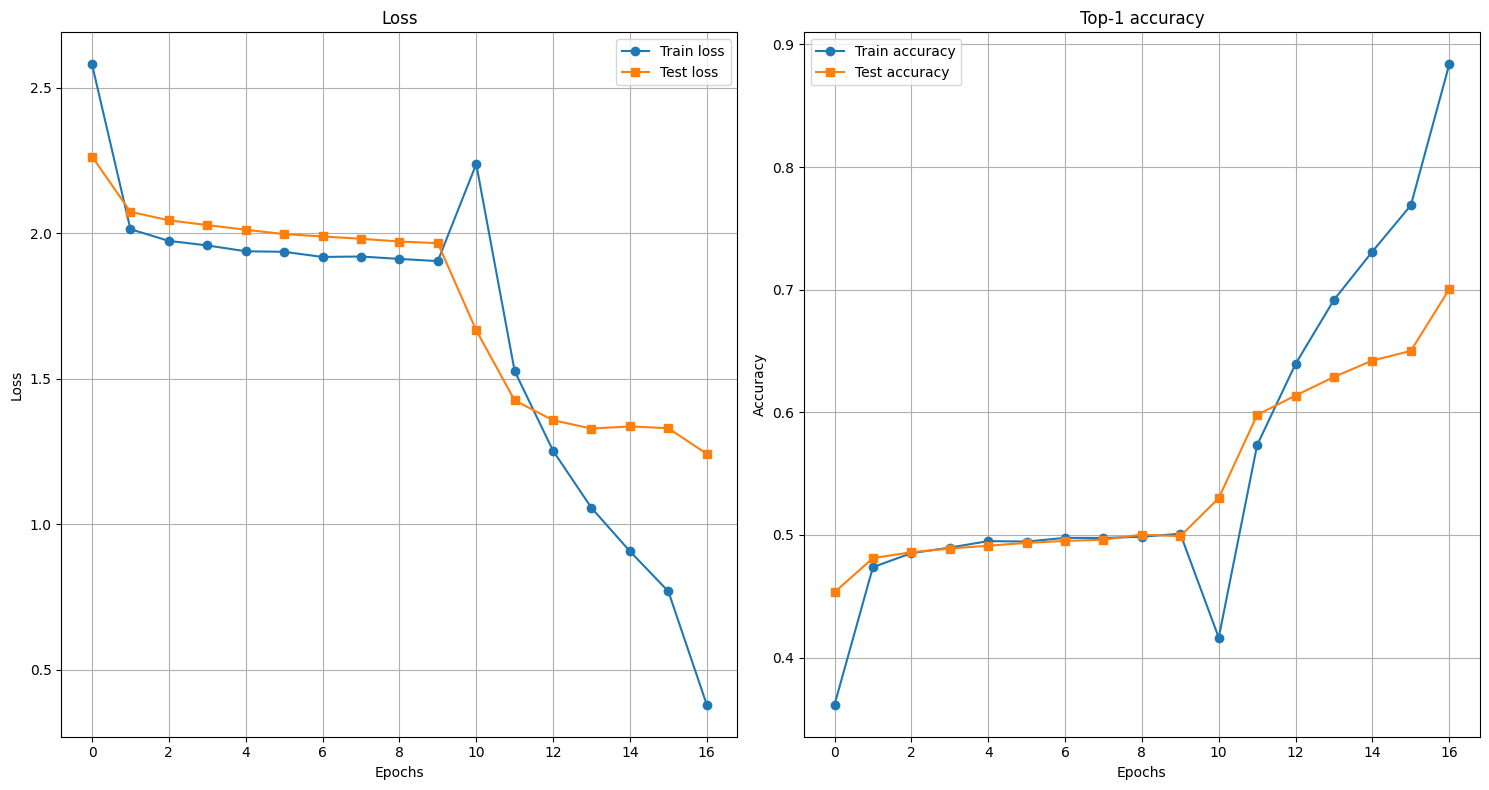

In [9]:
plot_history(param)

The methodology is the same for _CIFAR-10_, re-run the notebook with `dataset_name == CIFAR_10`.

The model weights are also saved [here]('./saved_models/CIFAR_10/fp32') and we get a model with the following performance :

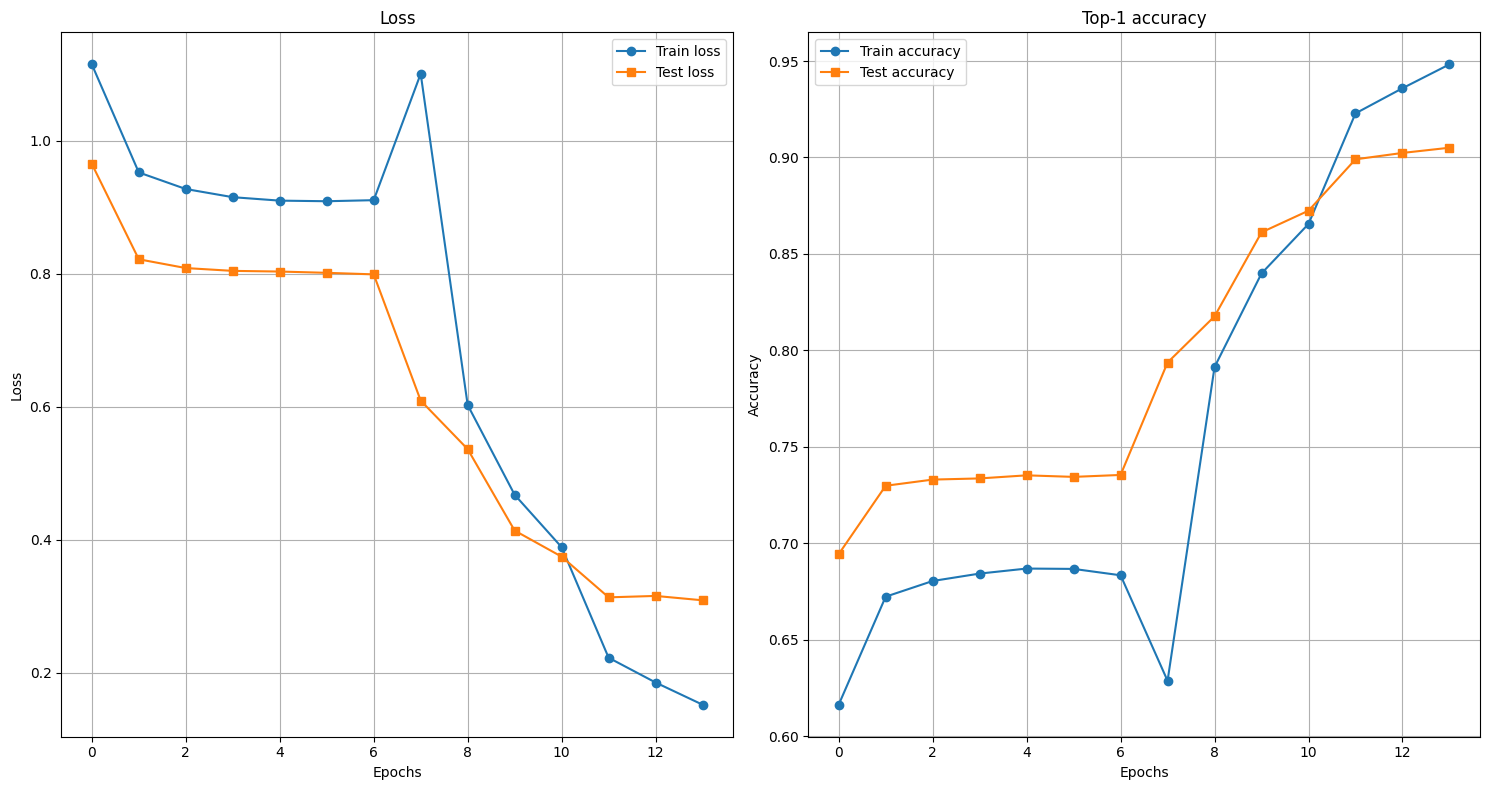

In [10]:
plot_history(param_c10, load=True)

The sharp fluctuations are due to the change in the learning rate.

# Conclusion

With such a simple architecture using `AvgPool2d`, $8$ convolutional layers and $1$ fully connected network, we achieve: 

Data-set  | Top-1 Accuracy | SOTA in $2022$
----------|----------------|----------------
CIFAR-10  | $90.504$%      | $99.612$%
CIFAR-100 | $70.042$%      | $96.808$%

In this notebook, we have shown how we obtained the weights needed to solve CIFAR-10 or CIFAR-100 classification task.
These weights will be reused in the next [tutorial]("CifarQuantizationAwareTraining.ipynb"). Where we'll use Brevitas to quantize these models as fully homomorphic encryption operates only over integer values.